In [17]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [18]:
import numpy as np
import pandas as pd

In [19]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [35]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [21]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [22]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [23]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [24]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [36]:
# Create our session (link) from Python to the DB
session = Session(engine)

#Call inspect to get keys
inspector = inspect(engine)

#Measurement Keys
mcolumns = inspector.get_columns('Measurement')
for m in mcolumns:
    print(m['name'], m["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [37]:
#Station Keys
scolumns = inspector.get_columns('Station')
for s in scolumns:
    print(s['name'], s['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

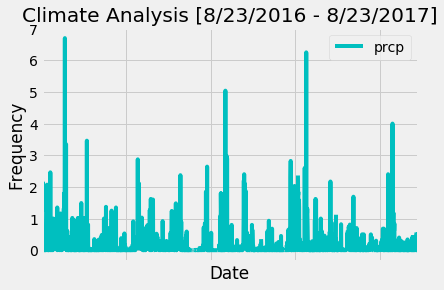

In [56]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
twelve_month_precip = session.query(Measurement.date).order_by(Measurement.date.desc()).first() 
# Calculate the date 1 year ago from the last data point in the database
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
precip_score = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date > last_year).order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_score)
# Sort the dataframe by date
precip_df.set_index('date').head
# Use Pandas Plotting with Matplotlib to plot the data
ax = precip_df.plot(color='c')

ax.set_title("Climate Analysis [8/23/2016 - 8/23/2017]")
ax.set_xlabel("Date")
ax.set_ylabel("Frequency")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.savefig("Images/ClimateAnalysis.png")
plt.show()

![precipitation](Images/precipitation.png)

In [57]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe() 

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [14]:
# Design a query to show how many stations are available in this dataset?
count = session.query(Measurement).group_by(Measurement.station).count()
count

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()

stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [28]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station = stations[0][0]

temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == station).all()
print(temps)

[(54.0, 85.0, 71.66378066378067)]


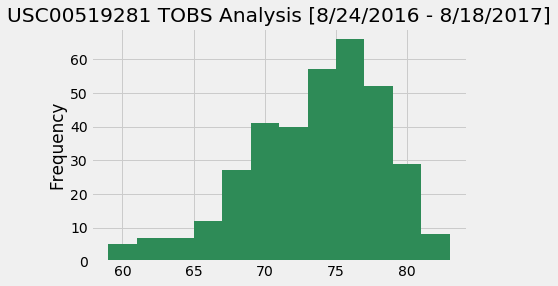

In [49]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
filter(Measurement.station == station, Measurement.date > last_year).order_by(Measurement.date).all()

tobs_df = pd.DataFrame(tobs)

plt.hist(tobs_df['tobs'], 12, color='seagreen')

plt.title("USC00519281 TOBS Analysis [8/24/2016 - 8/18/2017]")
plt.ylabel("Frequency")

plt.savefig("Images/StationAnalysis.png")
plt.show()

![precipitation](Images/station-histogram.png)

In [45]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [46]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip = calc_temps('2017-07-08', '2017-07-18')
print(my_trip)

#Convert Results into a dataframe for plot
plt_df = pd.DataFrame(my_trip, columns=['tmin', 'tavg', 'tmax'])

[(69.0, 78.35211267605634, 83.0)]


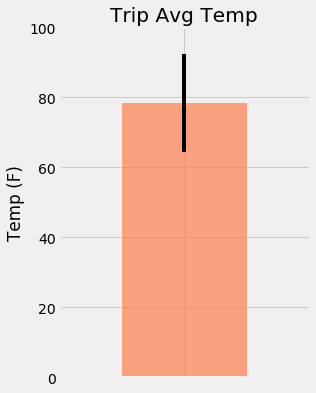

In [50]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt_df.plot.bar(y='tavg', yerr=(plt_df['tmax'] - plt_df['tmin']), color='coral', alpha=0.7, legend=None, figsize=(4, 6))

plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.ylim([0, 100])
plt.tick_params(
axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.savefig("Images/TOBSAnalysis.png")
plt.show()

In [48]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def rainfall(start_date, end_date):
        
    return session.query(Measurement.station, Station.name, Station.latitude, Station.longitude,\
                         Station.elevation, Measurement.prcp).filter(Measurement.station == Station.station,\
                                                                    Measurement.date >= start_date,\
                                                                    Measurement.date <= end_date).\
                                                             group_by(Measurement.station).\
                                                             order_by((Measurement.prcp).desc()).all()

print(rainfall('2017-07-08', '2017-07-18'))


[('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.06), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.02), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.02), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


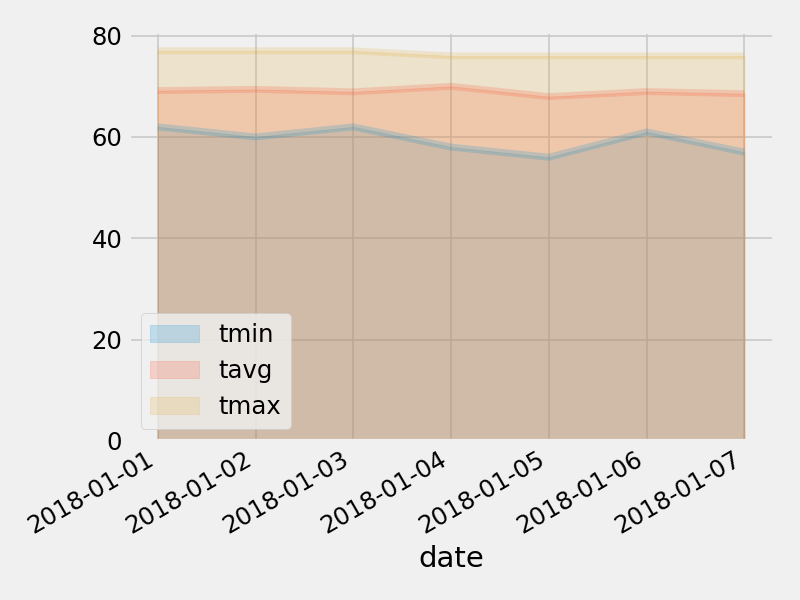

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
